# Analyzing a spotify dataset

## Importing libs and reading CSV

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from IPython.display import display, HTML

In [ ]:
uploaded = files.upload()

Saving spotify_data.csv to spotify_data.csv


In [ ]:
df = pd.read_csv('spotify_data.csv')

In [ ]:
df.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


## Understanding the dataset

### Does this dataset contains old songs, new songs or both?

In [ ]:
# Transforming songs release date to datetime format

df['album_release_date'] = pd.to_datetime(df['album_release_date'])

In [ ]:
# Visualizing the release year of the oldest and newest songs, and the  range between them

oldest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[0]
newest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[-1]
release_date_range = newest_song_year - oldest_song_year

display(HTML(f'The oldest song is from {oldest_song_year}.<br>The newest song is from {newest_song_year}.<br>The range is {release_date_range} years'))





**🎶 Therefore, the dataset contains both old and modern musics.**

### What's predominant, old or modern songs?

<Axes: xlabel='album_release_date', ylabel='Count'>

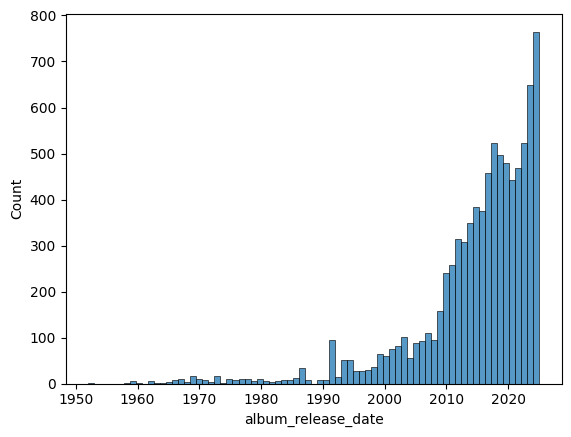

In [ ]:
# Creating a histplot to visualize predominant release years

df['album_release_date'] = df['album_release_date'].dt.year
sns.histplot(df, x='album_release_date')

In [ ]:
# Visualizing the number of songs per year
display(df['album_release_date'].value_counts().iloc[:10])

,count
album_release_date,
2025,765
2024,648
2023,523
2018,522
2019,496
2020,480
2022,468
2017,458
2021,443


In [ ]:
# Calculating the average year of song release

mean_release_date = df['album_release_date'].mean()

display(f"The average release date of songs in this dataset is {mean_release_date:.0f}")

'The average release date of songs in this dataset is 2015'

**Most of the songs are from 2010 - 2020, so modern songs are predominant.**

### How can we measure the success of a track?

In [ ]:
# We need to understand how to use the column 'track_popularity' to understand if a song is popular or not
# Maybe it could work as a rating or something? And what's the range of its values?

# Calculating the range
min_popularity = df['track_popularity'].min()
max_popularity = df['track_popularity'].max()
popularity_range = max_popularity - min_popularity

display(HTML(f'The max popularity is {max_popularity}.<br>The min popularity is {min_popularity}<br>The range of song popularity is {popularity_range}'))

So the popularity of tracks goes from 0 to 100.

With it, we can 'adapt' a rating from 0 to 10, just dividing the track's popularity by 10:

In [ ]:
df['track_popularity'] /= 10
display((df.sort_values(by='track_popularity', ascending=False).iloc[:10]))


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
457,1CPZ5BxNNd0n0nF4Orb9JS,Golden,4,9.9,False,HUNTR/X,87,3551538,k-pop,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.24
88,3yWuTOYDztXjZxdE2cIRUa,Opalite,3,9.7,False,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.92
101,1jgTiNob5cVyXeJ3WgX5bL,Elizabeth Taylor,2,9.5,False,Taylor Swift,100,145489371,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.47
337,1qbmS6ep2hbBRaEZFpn7BX,Man I Need,1,9.5,False,Olivia Dean,88,1499215,pop soul,0Bv6OJO0L5gcf20DMww54a,Man I Need,2025,3,single,3.06
103,03bTIHJElXZ0O0jqOQvAbY,Father Figure,4,9.4,True,Taylor Swift,100,145542136,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.54
1134,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,4,9.4,False,Billie Eilish,90,118692183,"alternative pop, electropop, dark pop",7aJuG4TFXa2hmE4z1yxc3n,HIT ME HARD AND SOFT,2024,10,album,3.50
450,02sy7FAs8dkDNYsHp4Ul3f,Soda Pop,3,9.4,False,Saja Boys,80,2234812,NaN,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,2.51
460,1I37Zz2g3hk9eWxaNkj031,Your Idol,7,9.3,False,Saja Boys,80,2234812,NaN,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.19
93,2x3mwb96B6TquRqMtbxUE1,Actually Romantic,7,9.3,True,Taylor Swift,100,145396321,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.72
97,5ylJtmaWPJ33cW3En7WOu0,Wood,9,9.3,True,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.50


## Data Cleaning

In [ ]:
# Checking the number of NaN values in the whole dataset

df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,3361
album_id,0


**There are 3361 rows without artist genres**

🎯 **Goal: Read artist names via some Spotify API and get their genre(s)**

### Separating artists without genre

In [ ]:
# Creating a separated df containing just the artist without genres and their number of followers
artists_without_genre = df[df['artist_genres'].isna()][['artist_name', 'artist_followers']]

# Selecting only artists with at least 10k followers
artists_without_genre = artists_without_genre[(artists_without_genre['artist_followers'] >= 10000)]

# Ordering by number of followers
artists_without_genre.sort_values(by='artist_followers', ascending=False, inplace=True)

display(artists_without_genre.tail())

,artist_name,artist_followers
355,Mandrazo,10272
1665,Prasewon,10229
5667,The Blue Notes,10148
620,Cloud,10130
3288,Olivia Herdt,10100


### Requesting Last.fm API

In [ ]:
import requests

buffer = artists_without_genre['artist_name'].to_list()
artists_without_genre = []

In [ ]:
# Removing duplicates
for artist in buffer:
  if artist not in artists_without_genre:
    artists_without_genre.append(artist)

buffer = []

url = 'http://ws.audioscrobbler.com/2.0/'
params = {
    'method': 'artist.getinfo',
    'api_key': '548594b2115d6da3efd5d816a0916ef5',
    'format': 'json'
}


read_artist_genres = {}
genres_list = []
readed = 0
total_artists_without_number = len(artists_without_genre)

for artist in artists_without_genre:
  readed += 1
  percent = (100 * readed) / total_artists_without_number
  display(f'{round(percent, 2)}%...')
  display(f"I'm reading the artist {artist}")
  params['artist'] = artist

  response = requests.get(url, params=params)

  if response.status_code != 200:
    continue

  display(response.status_code)

  data = response.json()

  if 'error' in data:
    continue

  for tags in data['artist']['tags']['tag']:
    display(f'Artist: {artist} | Tags: {tags['name']}')
    genres_list.append(tags['name'])

  read_artist_genres[artist] = genres_list
  genres_list = []

display(read_artist_genres)


### Merging with dataset

In [ ]:
# Turning dict with artists and genres into a Series to merge with the original DF
read_artist_genres = pd.Series(read_artist_genres)

read_artist_genres = df[df['artist_genres'].isna()]['artist_name'].map(read_artist_genres)

# Removing artists with null genre
read_artist_genres.dropna(axis=0, inplace=True)

read_artist_genres


,artist_name
2,"[Hip-Hop, rap, heavy metal, Progressive rock, ..."
12,"[rnb, soul, Neo-Soul, Canadian, alternative rnb]"
15,"[jazz, soul, funk, spiritual jazz, free jazz]"
19,[]
23,"[pop, british, rnb, indie, dark pop]"
...,...
8545,"[singer-songwriter, classic rock, folk, blues,..."
8547,"[Soundtrack, italian, composer, spaghetti west..."
8560,"[Soundtrack, instrumental, composer, spaghetti..."
8571,"[soul, 60s, blues, oldies, classic rock]"


In [ ]:
# Dropping artists with empty genre list
read_artist_genres = read_artist_genres[read_artist_genres.apply(len) > 0]


read_artist_genres

,artist_name
2,"[Hip-Hop, rap, heavy metal, Progressive rock, ..."
12,"[rnb, soul, Neo-Soul, Canadian, alternative rnb]"
15,"[jazz, soul, funk, spiritual jazz, free jazz]"
23,"[pop, british, rnb, indie, dark pop]"
37,"[pop, female vocalists, eurovision 2021, San M..."
...,...
8512,"[Soundtrack, italian, jazz, composer, film score]"
8545,"[singer-songwriter, classic rock, folk, blues,..."
8547,"[Soundtrack, italian, composer, spaghetti west..."
8560,"[Soundtrack, instrumental, composer, spaghetti..."


In [ ]:
# Filling artists genres in empty (NaN) fields
df['artist_genres'].fillna(read_artist_genres, inplace=True)

display(df)

/tmp/ipython-input-3436755969.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['artist_genres'].fillna(read_artist_genres, inplace=True)


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0.0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0.0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,0.4,True,Riff Raff,48,193302,"[Hip-Hop, rap, heavy metal, Progressive rock, ...",3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,3.0,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0.0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025,2,single,2.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,0AQquaENerGps8BQmbPw14,Big Iron,1,7.1,False,Marty Robbins,60,626733,"classic country, outlaw country",3kQpBS26lAj0A0VGl1snRl,Gunfighter Ballads And Trail Songs,1959,15,album,3.92
8578,4f8hBeMXMvssn6HtFAtblo,El Paso,10,6.4,False,Marty Robbins,61,626733,"classic country, outlaw country",3kQpBS26lAj0A0VGl1snRl,Gunfighter Ballads And Trail Songs,1959,15,album,4.32
8579,0Vy7wsXNFrbNc6UTWoScnM,Over the Rainbow,5,0.8,False,The Mystics,27,18184,doo-wop,2ifB9Xjp9DdpqLlYlY60QW,Presenting The Mystics,1959,9,compilation,2.28
8580,760clbeDBWmBsBLbszWuNZ,I'm A Man,2,5.5,False,Bo Diddley,44,333376,"blues, classic blues, rock and roll, rockabilly",1cbtDEwxCjMhglb49OgNBR,Bo Diddley,1958,12,album,2.74


In [ ]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,571
album_id,0


## Exploratory Data Analysis (EDA)

### Who are the top artists, and what do they have in common?

In [ ]:
# To filter the top artists, I can calculate the song popularity average of their songs, and select only those who have at least five songs

artists_5plus = df[df['artist_name'].value_counts()[df['artist_name']] >= 5]
display(artists_5plus)


KeyError: '[nan] not in index'

### What are the parameters that make a song popular?